<a href="https://colab.research.google.com/github/plaban1981/Langchain_usecases/blob/main/Semi_structured_and_multi_modal_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Semi-structured RAG
Many documents contain a mixture of content types, including text and tables.

Semi-structured data can be challenging for conventional RAG for at least two reasons:

Text splitting may break up tables, corrupting the data in retrieval
Embedding tables may pose challenges for semantic similarity search
This cookbook shows how to perform RAG on documents with semi-structured data:

* We will use Unstructured to parse both text and tables from documents (PDFs).
* We will use the multi-vector retriever to store raw tables, text along with table summaries better suited for retrieval.
* We will use LCEL to implement the chains used.

The overall flow is here:

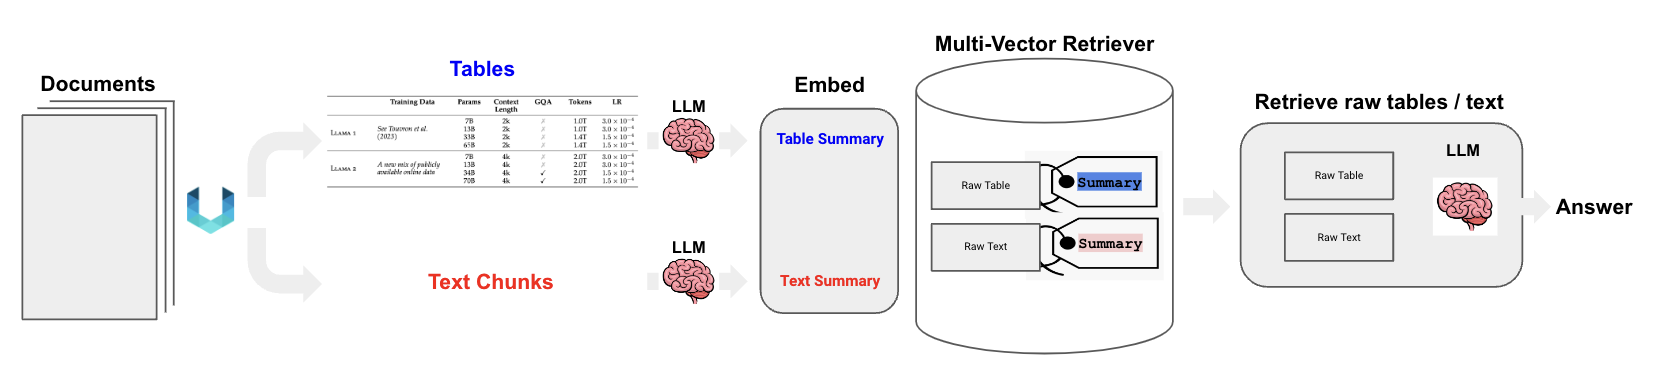

In [4]:
%%capture
! pip install langchain unstructured[all-docs] pydantic lxml langchainhub

The PDF partitioning used by Unstructured will use:

* tesseract for Optical Character Recognition (OCR)
* poppler for PDF rendering and processing

In [8]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.3 [186 kB]
Fetched 186 kB in 0s (406 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 120899 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.3_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.3) ...
Setting up poppler-utils (22.02.0-2ubuntu0.3) ...
Processing triggers for man-db (2.10.2-1) ...


In [9]:
! apt install tesseract-ocr
! apt install libtesseract-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 15 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (9,088 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 120929 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [ ]:
! pip install Pillow
! pip install pytesseract

In [10]:
!pip install llama-cpp-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 22.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.2.20-cp310-cp310-manylinux_2_35_x86_64.whl size=1987632 sha256=786ffdafb273675589290e3f386b2b16739ee4d08ab851cc69199fc74309df1a
  Stored in directory: /root/.cache/pip/wheels/ef/f2/d2/0becb03047a348d7bd9a5b91ec88f4654d6fa7d67ea4e84d43
Successfully built llama-cpp-python


## Data Loading
Partition PDF tables and text


* We use the Unstructured partition_pdf, which segments a PDF document by using a layout model.

* This layout model makes it possible to extract elements, such as tables, from pdfs.

* We also can use Unstructured chunking, which:

  - Tries to identify document sections (e.g., Introduction, etc)
  - Then, builds text blocks that maintain sections while also honoring user-defined chunk sizes

In [1]:
import os
os.mkdir("documents")

FileExistsError: ignored

In [2]:
import shutil
shutil.move("/content/2307.09288v2.pdf", "documents")

'documents/2307.09288v2.pdf'

In [11]:
path = "/content/documents/"
from typing import Any

from pydantic import BaseModel
from unstructured.partition.pdf import partition_pdf

# Get elements
raw_pdf_elements = partition_pdf(
    filename=path + "2307.09288v2.pdf" ,
    # Unstructured first finds embedded image blocks
    extract_images_in_pdf=False,
    # Use layout model (YOLOX) to get bounding boxes (for tables) and find titles
    # Titles are any sub-section of the document
    infer_table_structure=True,
    # Post processing to aggregate text once we have the title
    chunking_strategy="by_title",
    # Chunking params to aggregate text blocks
    # Attempt to create a new chunk 3800 chars
    # Attempt to keep chunks > 2000 chars
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path,
)

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Examine the elements extracted by partition_pdf.

```CompositeElement``` are aggregated chunks.

In [12]:
# Create a dictionary to store counts of each type
category_counts = {}

for element in raw_pdf_elements:
    category = str(type(element))
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# Unique_categories will have unique elements
unique_categories = set(category_counts.keys())
category_counts

{"<class 'unstructured.documents.elements.CompositeElement'>": 114,
 "<class 'unstructured.documents.elements.Table'>": 44,
 "<class 'unstructured.documents.elements.TableChunk'>": 6}

In [13]:
class Element(BaseModel):
    type: str
    text: Any


# Categorize by type
categorized_elements = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        categorized_elements.append(Element(type="table", text=str(element)))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        categorized_elements.append(Element(type="text", text=str(element)))

# Tables
table_elements = [e for e in categorized_elements if e.type == "table"]
print(len(table_elements))

# Text
text_elements = [e for e in categorized_elements if e.type == "text"]
print(len(text_elements))

50
114


## Multi-vector retriever
Use multi-vector-retriever to produce ```summaries of tables and, optionally, text```.

With the summary, we will also store the raw table elements.

```
* The summaries are used to improve the quality of retrieval, as explained in the multi vector retriever docs.

* The raw tables are passed to the LLM, providing the full table context for the LLM to generate the answer.

```

## Setup llm

In [8]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
from langchain.llms import LlamaCpp
llms = LlamaCpp(streamimg=True,
                model_path="/content/drive/MyDrive/llama_cpp/zephyr-7b-beta.Q4_K_M.gguf",
                temperature=0.5,
                top_p=1,
                max_tokens=500,
                model_kwargs={"gpu_layers":0,"stream":True,"threads":int(os.cpu_count()/2)},
                n_ctx =4096,
                verbose=True)

/usr/local/lib/python3.10/dist-packages/langchain_core/utils/utils.py:159: UserWarning: WARNING! streamimg is not default parameter.
                streamimg was transferred to model_kwargs.
                Please confirm that streamimg is what you intended.
  warnings.warn(
AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


In [10]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.4/221.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [4]:
from langchain.chat_models import ChatOpenAI
from getpass import getpass
os.environ["OPENAI_API_KEY"] = getpass()
llms = ChatOpenAI(openai_api_key=os.getenv("OPENAI_API_KEY"),
                  temperature=0.5,
                  top_p=1,
                  max_tokens=500,)

··········


                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.


## Summaries

In [14]:
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

#### We create a simple summarize chain for each element.

In [15]:
# Prompt
prompt_text = """You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text. Table or text chunk: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
summarize_chain = {"element": lambda x: x} | prompt | llms | StrOutputParser()

In [16]:
# Apply to tables
tables = [i.text for i in table_elements]
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

In [17]:
table_summaries

['The table or text chunk provided contains various sections and subsections related to the pretraining, training, evaluation, and safety aspects of the Llama 2 model. It includes details such as pretraining data, training methods, evaluation results, fine-tuning techniques, system message for multi-turn consistency, safety measures, learnings and observations, limitations, ethical considerations, and responsible release strategy. Additional details and contributions are also mentioned in subsections A.1 to A.7.',
 'The table provides information on the training data parameters and context length for different models. It includes details such as the number of tokens, learning rate, and the reference for further information.',
 'The table provides information on the time (in GPU hours), power consumption (in watts), and carbon emissions (in tCO2eq) for different quantities of data processed. The values for time, power consumption, and carbon emissions increase as the quantity of data pr

In [18]:
# Apply to texts
texts = [i.text for i in text_elements]
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})

In [19]:
text_summaries

['The table and text provided are not related to each other. The table contains a sequence of alphanumeric characters, while the text is an abstract of a research paper discussing the development and release of a collection of pretrained and fine-tuned large language models (LLMs) called Llama 2. The Llama 2-Chat models are optimized for dialogue use cases and outperform open-source chat models on most benchmarks. The paper also describes the approach to fine-tuning and safety improvements of Llama 2-Chat, with the goal of enabling the community to build on their work and contribute to the responsible development of LLMs.',
 'The table shows the comparison of different models in terms of loss, win rate, and safety. Figure 1 presents the human evaluation results for the helpfulness of Llama 2-Chat compared to other models, indicating that Llama 2-Chat performs well. Figure 2 displays the win-rate percentage for helpfulness and safety between commercial-licensed models and Llama 2-Chat, 

## Add to vectorstore
Use Multi Vector Retriever with summaries:

* InMemoryStore stores the raw text, tables
* vectorstore stores the embedded summaries

In [20]:
! pip install chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.4/502.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 699.4/699.4 kB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.6/72.6 kB 9

In [21]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.


In [22]:
import uuid
import os
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.schema.document import Document
from langchain.storage import InMemoryStore
from langchain.vectorstores import Chroma

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="summaries",
                     embedding_function=OpenAIEmbeddings(openai_api_key=os.getenv('OPENAI_API_KEY')))

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=s, metadata={id_key: table_ids[i]})
    for i, s in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

## RAG Pipelines using LCEL

In [23]:
from langchain.schema.runnable import RunnablePassthrough

# Prompt template
template = """Answer the question based only on the following context, which can include text and tables:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# LLM
model = ChatOpenAI(temperature=0, model="gpt-4")

# RAG pipeline
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [25]:
chain.invoke("What is the number of training tokens for LLaMA2?")

'The Llama 2 models were trained on 2 trillion tokens of data.'

In [27]:
chain.invoke("What is the Rewardmodelresult associated with Meta Safety for GPT-4?")

'The text does not provide specific Reward Model Results associated with Meta Safety for GPT-4.'

In [32]:
chain.invoke("What is the % usage of the most commonly used gender pronoun ?")

'The most commonly used gender pronoun is "He" with a usage of 86.38%.'

In [30]:
chain.invoke("What is the percentage of Englisg language of all the languages described in the content?")

'The percentage of English language of all the languages described in the content is 89.70%.'

In [31]:
chain.invoke("What is the context lengh of Llama 2 13 B model?")

'The text does not provide information on the context length of the Llama 2 13B model.'

In [33]:
chain.invoke("What does the table for performance metrics describes?")

'The table for performance metrics describes the performance of different models (NaturalQuestions, MPT, Falcon, Llama 1, Llama 2, Pretrained, Fine-tuned ChatGPT, MPT-instruct, Falcon-instruct, and TruthfulQA) across various parameters (such as 7B, 30B, 40B, 13B, 33B, 65B, 34B, 70B, etc.). The performance is represented numerically, indicating that these could be scores or percentages.'

In [34]:
chain.invoke("What is the performance score for MPT?")

'The text provides multiple performance scores for MPT across different benchmarks and model sizes. Here are a few:\n\n- In the Human-Eval MBPP benchmark, MPT with 7B model size has a pass@1 score of 0.0 and pass@100 score of 0.6. With 40B model size, it has a pass@1 score of 11.2 and pass@100 score of 29.8.\n- In the SQUAD (EM) QUAC (f1) benchmark, MPT with 7B model size has a 0-shot score of 59.5, 1-shot score of 74.7, 4-shot score of 62.6, and 5-shot score of 62.7. With 30B model size, it has a 0-shot score of 74.2, 1-shot score of 62.8, 4-shot score of 72.4, and 5-shot score of 74.2.\n- In the TruthfulQA ↑ ToxiGen ↓ benchmark, MPT-instruct with 7B model size has a score of 16.33.'